Generative Adversarial Networks (GANs)
======================

Artigo original: [Goodfellow et al (2020)](https://dl.acm.org/doi/abs/10.1145/3422622)

Duas redes generativas "competem" em um contexto determinado.

A rede Generativa, por meio de um vetor D-dimensional $V_{noise}$ gera imagens "falsas", as quais são embaralhadas a imagens reais.
A rede Discriminativa deve identificar as imagens reais e as imagens falsas.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os

Espaço latente
===============

Espaço latente é um espaço de dimensão reduzida onde os dados são representados de maneira compacta e significativa. Os vetores latentes são pontos neste espaço. Cada vetor latente pode ser mapeado para uma amostra no espaço original dos dados (por exemplo, uma imagem, texto ou som).

Vetor latente
______________

1. **Representação Compacta:** Um vetor latente é uma representação compacta e densa de uma amostra. Por exemplo, uma imagem de alta resolução pode ser representada por um vetor latente de dimensão muito menor do que o número total de pixels da imagem.

2. **Dimensionalidade Reduzida:** O vetor latente possui uma dimensionalidade menor em comparação com os dados originais, o que ajuda a capturar os padrões mais importantes dos dados. Isso significa que o vetor latente retém as informações mais relevantes de maneira condensada.

3. **Entrada para Modelos Geradores:** Em modelos como GANs, o vetor latente serve como entrada para o gerador, que transforma esse vetor em uma amostra do espaço original (como uma imagem, som ou texto). Diferentes vetores latentes podem gerar diferentes amostras, e pequenas mudanças no vetor latente podem resultar em variações na amostra gerada.

In [ ]:
# Parâmetros
latent_dim = 100

latent_dim = 100
=================

* **Dimensão do Espaço Latente:** O número 100 indica que o vetor latente tem 100 componentes ou dimensões. Isso significa que cada vetor latente `z` é um vetor de comprimento 100, onde cada componente é geralmente um número amostrado de uma distribuição normal padrão (distribuição Gaussiana com média 0 e desvio padrão 1).
* **Complexidade e Variedade:** O valor de 100 foi escolhido para fornecer ao gerador uma quantidade suficiente de variabilidade e capacidade para gerar uma ampla gama de imagens diferentes. Um vetor latente de alta dimensionalidade pode capturar mais nuances e detalhes nas amostras geradas, o que é útil para produzir imagens de alta qualidade e diversidade.

* **Equilíbrio:** 100 é um valor comumente usado em muitas aplicações práticas de GANs, porque ele fornece um bom equilíbrio entre a capacidade do gerador de aprender padrões complexos e a eficiência computacional. Vetores latentes muito pequenos (por exemplo, 10 ou 20 dimensões) podem limitar a expressividade do gerador, enquanto vetores muito grandes (por exemplo, 1000 ou mais dimensões) podem tornar o treinamento mais difícil e instável, além de exigir mais recursos computacionais.

In [ ]:
img_shape = (1, 28, 28)
batch_size = 64
epochs = 20
learning_rate = 0.0002

In [ ]:
# Dispositivo (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Pipeline para transformação de dados
transform = transforms.Compose([
    # Transformação para tensores de entrada. Cores RGB variam de [0, 255]. Transforma-se para variarem entre [0.0, 1.0]
    transforms.ToTensor(),
    # Normaliza-se os tensores, subtraindo de um mean = [0.5] e divide-se de um std = [0.5]. Os valores passam a varia entre [-1.0, 1.0]
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
# Carregar dataset MNIST
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.77MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]


Gerador (Generator)
====================

* **Função:** Cria dados falsos que se pareçam com os dados reais. Ele recebe como entrada um vetor de ruído (também chamado de vetor latente), que é geralmente amostrado de uma distribuição simples, como uma distribuição normal. O gerador transforma esse vetor de ruído em uma amostra no espaço dos dados, como uma imagem, um texto, ou outro tipo de dado que se deseja gerar.

* **Estrutura:** O gerador é uma rede neural que geralmente contém camadas como `Linear`, `ConvTranspose2d`, `ReLU`, `BatchNorm`, etc. Essas camadas têm como objetivo transformar o vetor latente em uma representação complexa que, eventualmente, se torna uma amostra de dados semelhante às amostras reais do conjunto de treinamento.

* **Objetivo:** O objetivo do gerador é enganar o discriminador, fazendo com que ele classifique as amostras geradas como "reais". Durante o treinamento, os parâmetros do gerador são ajustados para maximizar a probabilidade de o discriminador classificar suas saídas como reais.

* **Função de Perda:** A função de perda do gerador geralmente tenta maximizar o valor logarítmico da probabilidade do discriminador classificar as amostras geradas como reais, ou, alternativamente, minimizar o valor logarítmico da probabilidade de o discriminador classificá-las como falsas.

In [ ]:
# Gerador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

Discriminador (Discriminator)
============================

* **Função:** O discriminador é responsável por distinguir entre amostras reais (do conjunto de treinamento) e amostras falsas (geradas pelo gerador). Ele recebe uma amostra como entrada e retorna uma probabilidade de que a amostra seja real (ou seja, pertencente ao conjunto de dados real) ou falsa (ou seja, gerada pelo gerador).

* **Estrutura:** O discriminador também é uma rede neural, mas geralmente é uma rede de classificação binária. Ele pode incluir camadas como `Conv2d`, `LeakyReLU`, `Flatten`, `Linear`, `Sigmoid`, etc. Essas camadas são projetadas para extrair características da entrada e decidir se a amostra é real ou falsa.

* **Objetivo:** O objetivo do discriminador é identificar corretamente se uma amostra é real ou falsa. Durante o treinamento, os parâmetros do discriminador são ajustados para maximizar a precisão na classificação de amostras reais e falsas.

* **Função de Perda:** A função de perda do discriminador é geralmente a soma das perdas de classificação das amostras reais e falsas. Ele tenta maximizar a probabilidade de classificar corretamente as amostras reais como reais e minimizar a probabilidade de classificar erroneamente as amostras falsas como reais.

In [ ]:
# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [ ]:
# Instanciar os modelos
generator = Generator().to(device)
discriminator = Discriminator().to(device)

Momentos do ADAM
================

$$ Adam = AdaGRAD + RMSProp $$

AdaGRAD = lida bem com a espasidade dos dados;

RMSProp = lida bem com gradientes explodindo ou desaparecendo.

O Adam calcula momentos de 1ª e 2ª ordem dos gradientes para adaptar a taxa de aprendizado de cada parâmetro.

1ª Ordem = médias móveis dos gradientes;

2ª Ordem = quadrado dos gradientes.

Parâmetros `beta` do Adam:

`beta1 = 0.5`

Controla a taxa de decaimento exponencial para o cálculo do momento de primeira ordem (a média dos gradientes).

* O momento de primeira ordem é basicamente uma média móvel dos gradientes ao longo do tempo.
* Um valor de beta1 mais próximo de 1 dá mais importância aos gradientes passados, acumulando uma média mais estável, mas que responde mais lentamente às mudanças nos gradientes.
* Um valor de beta1 mais baixo (como 0.5) permite que o otimizador responda mais rapidamente às mudanças no gradiente, o que pode ser útil em situações onde o treinamento é instável, como no caso de GANs.
* Por que 0.5?: Em GANs, é comum usar beta1 = 0.5 porque isso ajuda a estabilizar o treinamento. O treinamento de GANs pode ser instável e o ajuste desse valor para 0.5 ajuda a reduzir oscilações indesejadas no aprendizado.

`beta2 = 0.999`

Controla a taxa de decaimento exponencial para o cálculo do momento de segunda ordem (a variância dos gradientes).

* O momento de segunda ordem é uma média móvel do quadrado dos gradientes.
* Um valor de beta2 mais próximo de 1 significa que o otimizador considera a maioria das iterações anteriores para calcular a variância, o que suaviza as atualizações do modelo.
* Um valor de beta2 mais baixo faria com que o otimizador respondesse mais rapidamente a mudanças na variância dos gradientes.
* Por que 0.999?: Este é um valor padrão que funciona bem na maioria dos casos. Ele assegura que as estimativas de segunda ordem sejam estáveis e que o modelo não faça grandes mudanças com base em flutuações temporárias nos gradientes.

In [ ]:
# Função de perda e otimizadores
criterion = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

Interação entre Gerador e Discriminador - Adversarial learning
=====================================

1. **Treinamento Adversarial:** O treinamento de uma GAN envolve um jogo entre o gerador e o discriminador:

* O gerador tenta melhorar suas amostras para enganar o discriminador.
* O discriminador tenta melhorar sua capacidade de distinguir entre amostras reais e falsas.

2. **Ciclo de Treinamento:**
* Discriminador: É treinado primeiro em amostras reais e falsas. Ele aprende a identificar corretamente quais são reais e quais são falsas.
* Gerador: Após o discriminador ser treinado, o gerador é treinado para melhorar a qualidade de suas amostras, baseando-se no feedback que recebe do discriminador.

3. **Convergência:** Idealmente, o treinamento continua até que o discriminador não consiga mais distinguir entre amostras reais e geradas (ou seja, ambas têm 50% de chance de serem classificadas como reais), o que significa que o gerador está criando amostras realistas.

In [ ]:
# Função para treinar o modelo
from IPython.display import Image, display

def train_dcgan(generator, discriminator, dataloader, criterion, optimizer_G, optimizer_D, epochs):
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):
            # Labels para real e falso
            real_labels = torch.ones(imgs.size(0), 1).to(device)
            fake_labels = torch.zeros(imgs.size(0), 1).to(device)

            # Treinar o Discriminador
            optimizer_D.zero_grad()
            real_imgs = imgs.to(device)
            real_loss = criterion(discriminator(real_imgs), real_labels)
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z)
            fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Treinar o Gerador
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_imgs), real_labels)
            g_loss.backward()
            optimizer_G.step()

            # Printar o progresso
            if i % 400 == 0:
                print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(dataloader)} Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

        # Salvar algumas imagens geradas após cada época
        image_path = f"images_dgan/dcgan_{epoch}.png"
        save_image(fake_imgs[:25], image_path, nrow=5, normalize=True)
        # Mostrar as imagens geradas
        print(f"Generated images after Epoch {epoch}:")
        display(Image(filename=image_path))

In [ ]:
# Verificar e criar o diretório 'images' se ele não existir
if not os.path.exists('images_dgan'):
    os.makedirs('images_dgan')

Epoch [0/20] Batch 0/938 Loss D: 1.436111569404602, Loss G: 0.8383451700210571
Epoch [0/20] Batch 400/938 Loss D: 0.3887093663215637, Loss G: 2.031930923461914
Epoch [0/20] Batch 800/938 Loss D: 0.25488394498825073, Loss G: 3.308882713317871
Generated images after Epoch 0:


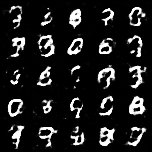

Epoch [1/20] Batch 0/938 Loss D: 0.18637442588806152, Loss G: 2.1117725372314453
Epoch [1/20] Batch 400/938 Loss D: 0.27021920680999756, Loss G: 3.7577357292175293
Epoch [1/20] Batch 800/938 Loss D: 0.30344679951667786, Loss G: 2.183199405670166
Generated images after Epoch 1:


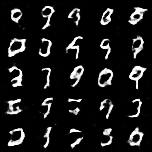

Epoch [2/20] Batch 0/938 Loss D: 0.3031078577041626, Loss G: 1.5686641931533813
Epoch [2/20] Batch 400/938 Loss D: 0.14864875376224518, Loss G: 3.1067447662353516
Epoch [2/20] Batch 800/938 Loss D: 0.21260866522789001, Loss G: 2.9932432174682617
Generated images after Epoch 2:


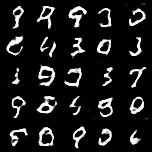

Epoch [3/20] Batch 0/938 Loss D: 0.3160385191440582, Loss G: 3.3649942874908447
Epoch [3/20] Batch 400/938 Loss D: 0.2479444146156311, Loss G: 3.378483772277832
Epoch [3/20] Batch 800/938 Loss D: 0.2865130603313446, Loss G: 3.4153342247009277
Generated images after Epoch 3:


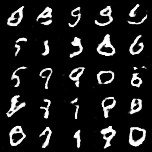

Epoch [4/20] Batch 0/938 Loss D: 0.42626872658729553, Loss G: 2.933851957321167
Epoch [4/20] Batch 400/938 Loss D: 0.182352215051651, Loss G: 3.7144083976745605
Epoch [4/20] Batch 800/938 Loss D: 0.40106695890426636, Loss G: 3.478281021118164
Generated images after Epoch 4:


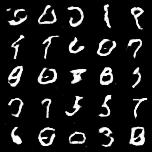

Epoch [5/20] Batch 0/938 Loss D: 0.2558804154396057, Loss G: 3.365631580352783
Epoch [5/20] Batch 400/938 Loss D: 0.2778877913951874, Loss G: 1.9209294319152832
Epoch [5/20] Batch 800/938 Loss D: 0.2687716484069824, Loss G: 2.9755969047546387
Generated images after Epoch 5:


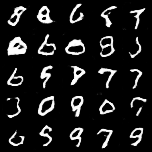

Epoch [6/20] Batch 0/938 Loss D: 0.2982374131679535, Loss G: 3.2493910789489746
Epoch [6/20] Batch 400/938 Loss D: 0.3398645520210266, Loss G: 2.8584158420562744
Epoch [6/20] Batch 800/938 Loss D: 0.25663620233535767, Loss G: 2.975656270980835
Generated images after Epoch 6:


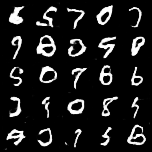

Epoch [7/20] Batch 0/938 Loss D: 0.17306342720985413, Loss G: 3.290043354034424
Epoch [7/20] Batch 400/938 Loss D: 0.08317946642637253, Loss G: 4.372891902923584
Epoch [7/20] Batch 800/938 Loss D: 0.23432698845863342, Loss G: 2.319040298461914
Generated images after Epoch 7:


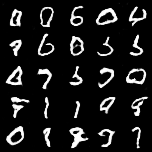

Epoch [8/20] Batch 0/938 Loss D: 0.26435160636901855, Loss G: 4.7012434005737305
Epoch [8/20] Batch 400/938 Loss D: 0.2812916934490204, Loss G: 3.484689712524414
Epoch [8/20] Batch 800/938 Loss D: 0.37598878145217896, Loss G: 4.053584098815918
Generated images after Epoch 8:


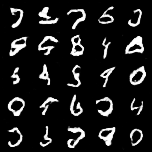

Epoch [9/20] Batch 0/938 Loss D: 0.2689145505428314, Loss G: 3.952214241027832
Epoch [9/20] Batch 400/938 Loss D: 0.1578769087791443, Loss G: 4.108052730560303
Epoch [9/20] Batch 800/938 Loss D: 0.24778658151626587, Loss G: 2.980276107788086
Generated images after Epoch 9:


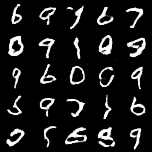

Epoch [10/20] Batch 0/938 Loss D: 0.28449857234954834, Loss G: 2.921593189239502
Epoch [10/20] Batch 400/938 Loss D: 0.5767009854316711, Loss G: 3.041846752166748
Epoch [10/20] Batch 800/938 Loss D: 0.2450280785560608, Loss G: 3.2374117374420166
Generated images after Epoch 10:


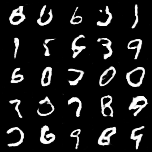

Epoch [11/20] Batch 0/938 Loss D: 0.5088250637054443, Loss G: 2.471482276916504
Epoch [11/20] Batch 400/938 Loss D: 0.3382399082183838, Loss G: 3.2801496982574463
Epoch [11/20] Batch 800/938 Loss D: 0.3579971194267273, Loss G: 3.883802652359009
Generated images after Epoch 11:


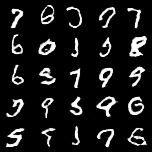

Epoch [12/20] Batch 0/938 Loss D: 0.5008560419082642, Loss G: 1.3291332721710205
Epoch [12/20] Batch 400/938 Loss D: 0.1977575570344925, Loss G: 4.078008651733398
Epoch [12/20] Batch 800/938 Loss D: 0.2906895875930786, Loss G: 2.650996208190918
Generated images after Epoch 12:


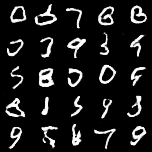

Epoch [13/20] Batch 0/938 Loss D: 0.515438437461853, Loss G: 1.0995068550109863
Epoch [13/20] Batch 400/938 Loss D: 0.4762715697288513, Loss G: 2.161496639251709
Epoch [13/20] Batch 800/938 Loss D: 0.24990439414978027, Loss G: 2.679929733276367
Generated images after Epoch 13:


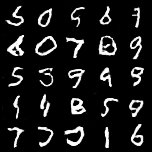

Epoch [14/20] Batch 0/938 Loss D: 0.23151983320713043, Loss G: 3.754228115081787
Epoch [14/20] Batch 400/938 Loss D: 0.16004642844200134, Loss G: 4.667474746704102
Epoch [14/20] Batch 800/938 Loss D: 0.28661829233169556, Loss G: 4.404428482055664
Generated images after Epoch 14:


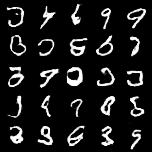

Epoch [15/20] Batch 0/938 Loss D: 0.29380226135253906, Loss G: 2.2398295402526855
Epoch [15/20] Batch 400/938 Loss D: 0.12204660475254059, Loss G: 4.269819259643555
Epoch [15/20] Batch 800/938 Loss D: 0.2144378125667572, Loss G: 3.297335147857666
Generated images after Epoch 15:


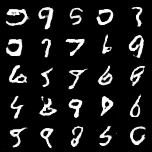

Epoch [16/20] Batch 0/938 Loss D: 0.29136666655540466, Loss G: 2.0482397079467773


KeyboardInterrupt: 

In [ ]:
# Treinar o modelo
train_dcgan(generator, discriminator, dataloader, criterion, optimizer_G, optimizer_D, epochs)

Loss D (Perda do discriminador)
------------------------------

A Loss D mede o quão bem o discriminador está distinguindo entre as amostras reais e as amostras geradas pelo gerador. Especificamente, é a soma da perda ao classificar as amostras reais (que o discriminador deve classificar como reais) e as amostras falsas (que o discriminador deve classificar como falsas).

* **No início do treinamento:** A Loss D geralmente começa alta, porque o gerador é inicializado com pesos aleatórios e, portanto, gera amostras que são facilmente distinguíveis como falsas.
* **Durante o treinamento:** À medida que o gerador melhora, a Loss D pode começar a diminuir, pois o discriminador terá mais dificuldade em distinguir entre as amostras reais e as falsas. Idealmente, a Loss D deve se manter em torno de 0.5 quando o gerador e o discriminador estão equilibrados, indicando que o discriminador tem 50% de chance de classificar corretamente, ou seja, não consegue distinguir bem as amostras reais das falsas.
* **Oscilações:** A Loss D pode oscilar, refletindo a "batalha" entre o gerador e o discriminador. Se a Loss D for muito baixa, o discriminador está muito bom; se for muito alta, o discriminador pode estar falhando em diferenciar as amostras.

Loss G (Perda do Gerador)
-------------------------

A Loss G mede o quão bem o gerador está enganando o discriminador. Especificamente, é calculada tentando maximizar a probabilidade de o discriminador classificar as amostras falsas como reais.

* **No início do treinamento:** A Loss G geralmente começa alta porque o gerador está gerando amostras aleatórias que o discriminador consegue identificar facilmente como falsas.
* **Durante o treinamento:** À medida que o gerador melhora e começa a gerar amostras mais realistas, a Loss G deve diminuir, indicando que o gerador está enganando o discriminador com mais frequência. No entanto, se a Loss G for muito baixa, pode significar que o gerador está "ganhando" demais, o que não é desejável, pois pode indicar que o discriminador não está treinando de forma eficaz.
* **Oscilações:** A Loss G também pode oscilar. Se a Loss G for muito alta, o gerador pode estar gerando amostras de baixa qualidade. Se for muito baixa, pode indicar que o discriminador não está aprendendo adequadamente.

Equilíbrio entre `Loss D` e `Loss G`
--------------------------------------

* **Equilíbrio:** Idealmente, durante o treinamento, deve haver um equilíbrio dinâmico entre Loss D e Loss G. Em outras palavras, ambas as perdas não devem ser consistentemente muito baixas ou muito altas, mas devem oscilar em torno de valores intermediários. Isso indicaria que o gerador está constantemente melhorando para enganar o discriminador, enquanto o discriminador está constantemente melhorando para identificar as amostras falsas.

* **Instabilidade:** Se uma perda (Loss D ou Loss G) se aproxima de 0 ou cresce sem limites, isso pode indicar instabilidade no treinamento. Por exemplo, se Loss D for quase 0, o discriminador está muito forte e o gerador pode não estar aprendendo nada útil. Se Loss G for quase 0, o gerador pode estar "vencendo" facilmente, e o discriminador pode não estar recebendo feedback útil para melhorar.

Mode Collapse
----------------

Às vezes, o gerador aprende a produzir uma quantidade limitada de amostras que enganam o discriminador repetidamente, levando a uma Loss G baixa, mas com baixa diversidade nas amostras geradas. Isso é conhecido como "mode collapse".

Treinamento instável
--------------------

As GANs são notórias por seu treinamento instável, onde o equilíbrio entre o gerador e o discriminador pode ser difícil de manter. Ajustes nos hiperparâmetros, como as taxas de aprendizado e o uso de técnicas de regularização, podem ser necessários para estabilizar o treinamento.

Resumo de monitoramento
---------------------

* **`Loss D:`** Idealmente, deve oscilar em torno de 0.5, indicando que o discriminador tem dificuldade em distinguir amostras reais das falsas.
* **`Loss G:`** Deve diminuir ao longo do tempo, mas não deve ser muito baixa, indicando que o gerador está aprendendo a enganar o discriminador, mas não completamente.
* **`Equilíbrio Dinâmico:`** O sucesso de uma GAN depende de um equilíbrio dinâmico entre Loss D e Loss G, onde ambos os modelos estão aprendendo de forma eficaz.